In [ ]:
from MITgcmutils.utils import writebin
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import xarray as xr
from scipy import ndimage

def fillna(arr):
    filled = arr.copy()
    if np.isnan(arr).any():
        mask = np.isnan(arr)
        # 获取最近非 NaN 元素的索引
        idx = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        filled[:, :] = arr[tuple(idx)]
    return filled
nx = 168   # gridpoints in x
ny = 36    # gridpoints in y
nz = 10    # gridpoints in z

dx = 1     # grid spacing in x (degrees longitude)
dy = 1     # grid spacing in y (degrees latitude)
x0 = 120     # origin in x,y for ocean domain
y0 = -18    # (i.e. southwestern corner of ocean domain)
x1 = x0 + (nx-1)*dx    # origin in x,y for ocean domain
y1 = y0 + (ny-1)*dy    # (i.e. southwestern corner of ocean domain)

opath = '../input/'

ipath = '/mnt/d/project/IAVNNG/Data/'
ipath = '../../Data/'
# input files
fbath = ipath + 'GLO-MFC_001_030_mask_bathy.nc'
fclim = ipath + 'cmems_climatology_mon.nc'
fwind = ipath + 'era5_tau_mon.nc'
inc = round(dx*12)
winc = round(dx*4)

## 生成海表面风应力场 （Agrid）

(12, 36, 168)


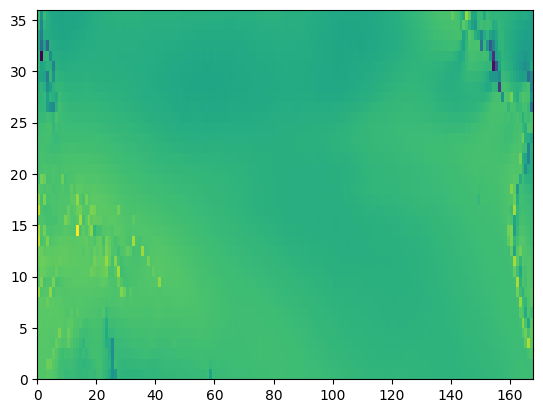

In [119]:
isclim = True
yrs = 10
ds = xr.open_dataset(fwind)

nt = ds['valid_time']
taux = ds['ewss'][:12*yrs].loc[:,y0:y1:-1*winc,x0:x1:winc] 
tauy = ds['nsss'][:12*yrs].loc[:,y0:y1:-1*winc,x0:x1:winc]

taux = taux.values/86400  # era5提供的风应力是一天的积分，需要除以86400转换为风应力
tauy = tauy.values/86400  # 同上
if isclim:
    taux = taux.reshape(-1,12,ny,nx).mean(0)
    tauy = tauy.reshape(-1,12,ny,nx).mean(0)
# taux[:,[0,-1],:] = 0
# tauy[:,[0,-1],:] = 0
plt.pcolormesh(taux[0])
print(taux.shape)
# 保存为MITgcm驱动所需的二进制文件
writebin(opath+'taux.bin',taux)
writebin(opath+'tauy.bin',tauy)

## 生成EXF Relax边界（SSH SSS Agrid）

(12, 36, 168)


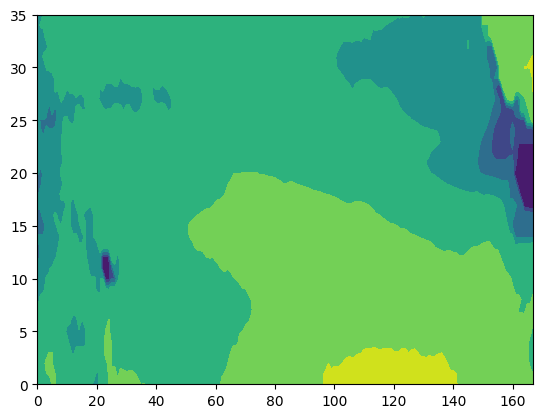

In [120]:

ds = xr.open_dataset(fclim)
thetao = ds['thetao'][:,0].loc[:,y0:y1:inc,x0:x1:inc]
so = ds['so'][:,0].loc[:,y0:y1:inc,x0:x1:inc]
theta = thetao.values
s = so.values
for i in range(thetao.shape[0]):
    theta[i] = fillna(theta[i])
    s[i] = fillna(s[i])
plt.contourf(s[0])
print(theta.shape)
writebin(opath+'sst_clim.bin',theta)
writebin(opath+'sss_clim.bin',s)


## 生成温盐流初始场

In [ ]:

ds = xr.open_dataset(fclim)
dep = ds['depth'].values
dr = np.zeros(dep.shape)
lev = 0
for i in range(dep.size):
    dr[i] = 2*(dep[i]-lev)
    lev += dr[i]
drr = dr.reshape(nz,-1).sum(-1)
dr = dr[:,None,None]
drr = drr[:,None,None]

ds = xr.open_dataset(fclim)
thetao = ds['thetao'][0].loc[:,y0:y1:inc,x0:x1:inc]
so = ds['so'][0].loc[:,y0:y1:inc,x0:x1:inc]
theta = thetao.values
s = so.values

for i in range(thetao.shape[0]):
    theta[i] = fillna(theta[i])
    s[i] = fillna(s[i])
Z, Y, X = theta.shape
# theta = (theta*dr).reshape(nz,Z//nz,Y,X).sum(1)/drr
# s = (s*dr).reshape(nz,Z//nz,Y,X).sum(1)/drr
theta =  np.nanmean(theta.reshape(nz,Z//nz,Y,X), 1)
s = np.nanmean(s.reshape(nz,Z//nz,Y,X), 1)

print(theta.shape)
writebin(opath+'T.bin',theta)
writebin(opath+'S.bin',s)


(10, 36, 168)


## 生成地形数据
---
需注意水深取负值，且将陆地填补为0

(36, 168)


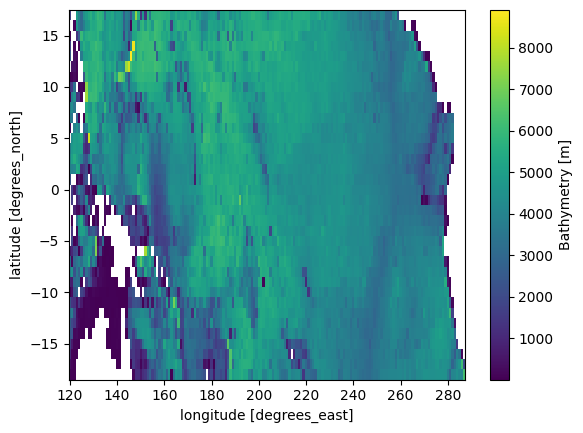

In [124]:
with xr.open_dataset(fbath) as ds:
    hl = ds['deptho'].loc[y0:y1:inc,x0:x1:inc].load()
    hr = ds['deptho'].loc[y0:y1:inc,x0-360:x1-360:inc].load()
    hr['longitude'] = hr['longitude'] + 360
    h = xr.concat([hl,hr],dim='longitude')

# 东边界
h.loc[18:,263:] = np.nan
h.loc[15.0:,271:] = np.nan
h.loc[8.8:,276:280] = np.nan
h.loc[9:,276:282.5] = np.nan
h.loc[8:,282.5:] = np.nan
# 西边界
# h.loc[13:,:121] = np.nan

h.plot()

h = h.values
h[np.isnan(h)] = 0
h = -h

print(h.shape)
writebin(opath+'bathy.bin',h)